# aside_DATA_remake_xtrain.ipynb
- 새로운 feature 늘려나가기
- Multi-Processing
- 데이터 전처리에 메모리도 많이 먹고, 시간도 오래걸림
- 병렬처리하면 5배 이상 빨라진다니 한번 시도해 봄


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import multiprocessing as mp

from parse import *
from multiprocessing import Pool

num_cores = mp.cpu_count()               # cpu의 코어 수를 반환
print(f"THIS CPU CORES ARE .. = {num_cores} CORES!")        # CPU CORES = 16 CORES!

THIS CPU CORES ARE .. = 16 CORES!


In [4]:
"""
# 기본 DIR 구조를 입력한다. - _assets 폴더 제외!
# /content/drive/My Drive/Colab Notebooks/
# dir_base = '/content/drive/My Drive/Colab Notebooks/competition/''
"""
dir_base = '/home/yk/0325_Starcraft/competition/'

raw      = 'c03_starcraft_prediction/data_raw/'
remake   = 'c03_starcraft_prediction/data_remake/'
submit   = 'c03_starcraft_prediction/data_submit/'

assets = '/home/yk/0325_Starcraft/competition/_assets'

filename_remake_final = 'df_xtrain_remake_final.csv'

In [5]:
"""
# 모듈 import를 위한 SYS.PATH 설정!
"""
import os
import sys

if not dir_base in sys.path:
    sys.path.insert(0, dir_base)
    print(f"***'{dir_base}' has set in SYS.PATH! ***")    
    print()
    
for i, item in enumerate(sys.path,1):
    print(f"{i:02}.{item}")

***'/home/yk/0325_Starcraft/competition/' has set in SYS.PATH! ***

01./home/yk/0325_Starcraft/competition/
02./home/yk/0325_Starcraft/competition/c03_starcraft_prediction/data_x_reference
03./home/yk/anaconda3/lib/python37.zip
04./home/yk/anaconda3/lib/python3.7
05./home/yk/anaconda3/lib/python3.7/lib-dynload
06.
07./home/yk/anaconda3/lib/python3.7/site-packages
08./home/yk/anaconda3/lib/python3.7/site-packages/IPython/extensions
09./home/yk/.ipython


### 사용함수의 정의

In [6]:
# from _assets.module_data_preps import ( __doc__,
#                                 tqdm,  
#                                 species_converter, 
#                                 data_preparation,
#                             )

from tqdm import tqdm

from _assets.modules import ( __doc__, 
                                show_ls, 
                                show_infoDF_from,
                                histit,
                                hist_it,
                                plot_it,
                                get_random_n_array,
                                get_basic_df,
                                get_counts_dict_fromDF,
                            )


# OS 화일 및 DF 정보조회를 위한 탐색 모듈



In [7]:
show_ls(assets )

False
DIR_TARGET=/home/yk/0325_Starcraft/competition/c03_starcraft_prediction/data_x_reference
/home/yk/0325_Starcraft/competition/_assets
----------------------------------------
  01. .ipynb_checkpoints
  02. __init__.py
  03. __pycache__
  04. config.py
  05. module_data_preps.py
  06. module_lgbm_model.py
  07. module_xgbm_model.py
  08. modules.py


## 2.0 Train Data Set 불러오기

| 컬럼명  | 값    | type     | 설명                  | 비고   |
|:-------:|:------|----------|-----------------------|--------|
| game_id |33781  |int       |경기 구분 기호         | unique (multiple) 
| winner  |0.6523 |float     |player-1 승리확률      | 0.6287
| time    |2.24   |float     |경기시간 (60분법 구분) | 2분24초
| player  |0      |int       |player 0 - 첫번째 선수 
|         |1      |int       |player 1 - 두번째 선수          
| species |T      |Object    |테란 (Terran)    |     
|         |P      |Object    |프로토스 (Protos)|      
|         |Z      |Object    |저그 (Zerg)      |      
| event   |Ability           |Object |생산, 공격 등 선수의 주요 행동
|         |AddToControlGroup |Object |부대에 추가
|         |Camera            |Object |시점 선택
|         |ControlGroup      |Object |부대 행동
|         |GetControlGroup   |Object |부대 불러오기
|         |Right             |Object |Click : 마우스 우클릭
|         |Selection         |Object |객체 선택
|         |SetControlGroup   |Object |부대 지정
|event_contents|@(좌표, 등)  | object|이벤트에 관한 상세설명 


 

## 이벤트 Detail 탐색을 위해 각 이벤트 딕트를 만든다
- df_train 을 읽어들인다 = 모든 분류소스의 오리지널 화일
- 이벤트 탐색을 위한 counts 이벤트 딕트를 만든다, 
- 각 이벤트를카운트한 시리즈

In [8]:
%%time
df_train = pd.read_csv(dir_base + raw + 'train.csv')

CPU times: user 1min 6s, sys: 11.1 s, total: 1min 17s
Wall time: 1min 50s


In [9]:
%%time
"""
# 이벤트 분류를 위한 counts_dict 를 만든다.
# CPU times: user 75.4 ms, sys: 2.81 ms, total: 78.2 ms
# Wall time: 77.6 ms
    """
counts = get_counts_dict_fromDF(df_train)

CPU times: user 2min 7s, sys: 1.43 s, total: 2min 8s
Wall time: 2min 6s


In [10]:
df_train.head(2)

,game_id,winner,time,player,species,event,event_contents
0,0,1,0.0,0,T,Camera,"at (145.25, 21.5078125)"
1,0,1,0.0,1,T,Camera,"at (22.75, 147.0078125)"


In [11]:
"""
# 미리 가공된 remake 데이터를 불러온다.
"""
x_train = pd.read_csv(dir_base + remake + 'df_xtrain_remake.csv')
y_train = pd.read_csv(dir_base + remake + 'df_ytrain_remake.csv', header=0, index_col='Unnamed: 0')
x_train.index = x_train['game_id'].copy()

In [12]:
x_train.shape      # (38872, 27)
x_train

,game_id,P0_species,P0_Ability,P0_AddToControlGroup,P0_Camera,P0_ControlGroup,P0_GetControlGroup,P0_Right Click,P0_Selection,P0_SetControlGroup,...,P1_Selection,P1_SetControlGroup,delta_Ability,delta_AddToControlGroup,delta_Camera,delta_ControlGroup,delta_GetControlGroup,delta_Right Click,delta_Selection,delta_SetControlGroup
game_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,34.0,2.0,444.0,0.0,24.0,35.0,50.0,3.0,...,57.0,1.0,0.0,2.0,19.0,0.0,21.0,7.0,-7.0,2.0
1,1,1,77.0,1.0,627.0,0.0,162.0,160.0,186.0,10.0,...,116.0,8.0,10.0,1.0,-231.0,0.0,131.0,29.0,70.0,2.0
2,2,1,69.0,6.0,413.0,0.0,99.0,160.0,90.0,14.0,...,232.0,9.0,-16.0,1.0,-312.0,-2.0,-10.0,-44.0,-142.0,5.0
3,3,0,82.0,0.0,713.0,0.0,132.0,276.0,180.0,6.0,...,148.0,19.0,-7.0,0.0,325.0,0.0,-578.0,8.0,32.0,-13.0
4,4,0,57.0,1.0,430.0,0.0,224.0,177.0,67.0,10.0,...,126.0,8.0,21.0,-3.0,158.0,0.0,125.0,71.0,-59.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38867,38867,0,43.0,0.0,639.0,0.0,0.0,95.0,53.0,1.0,...,58.0,0.0,11.0,0.0,315.0,0.0,0.0,52.0,-5.0,1.0
38868,38868,0,63.0,0.0,558.0,0.0,0.0,123.0,62.0,0.0,...,48.0,3.0,35.0,0.0,-75.0,0.0,-8.0,67.0,14.0,-3.0
38869,38869,1,56.0,0.0,785.0,0.0,28.0,248.0,106.0,4.0,...,191.0,6.0,3.0,-2.0,455.0,0.0,-61.0,81.0,-85.0,-2.0


In [13]:
y_train.shape      # (38872, 2)
y_train.head()

,game_id,winner
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0


In [14]:
x_train.shape   # (38872, 27)
y_train.shape   # (38872, 2) ???

False in (x_train.index.values == x_train.game_id.values)  # False
False in (y_train.index.values == y_train.game_id.values)  # False

y_train['winner'].value_counts()

1    19499
0    19373
Name: winner, dtype: int64

## Total time laps = df_time

In [15]:
%%time
"""
# df_time 데이터를 만든다. = 유니크 게임 갯수 *** DATA SHAPE = [ 38,872 x 1 ]
"""

df_time = pd.DataFrame(columns=['game_id'])       # 빈 df 선언
df_time['game_id'] = df_train['game_id'].unique() # 빈 df 에 'game_id 를 채운다
df_time['time_consum'] = np.array(df_train[df_train.shift(-1).game_id != df_train.game_id].time)

CPU times: user 12 s, sys: 11.1 s, total: 23.2 s
Wall time: 10.1 s


In [16]:
df_time.shape                         # (38872, 2) *** DATA SHAPE = [ 38,872 x 2 ]
df_time.head()

,game_id,time_consum
0,0,7.24
1,1,9.59
2,2,9.59
3,3,9.59
4,4,5.43


In [17]:
"""
# x_train 데이터 2번째 열에 Insert 시킨다
# df_1['old_index'] = df_1.index    # placed last
"""
pos_idx = 1                       # insert position
column = 'time_consum'            # name of column
value = df_time['time_consum']    # values

x_train.insert(pos_idx, column=column, value=value)

In [18]:
x_train.shape    # (38872, 28)
x_train.head()

,game_id,time_consum,P0_species,P0_Ability,P0_AddToControlGroup,P0_Camera,P0_ControlGroup,P0_GetControlGroup,P0_Right Click,P0_Selection,...,P1_Selection,P1_SetControlGroup,delta_Ability,delta_AddToControlGroup,delta_Camera,delta_ControlGroup,delta_GetControlGroup,delta_Right Click,delta_Selection,delta_SetControlGroup
game_id,,,,,,,,,,,,,,,,,,,,,
0,0,7.24,0,34.0,2.0,444.0,0.0,24.0,35.0,50.0,...,57.0,1.0,0.0,2.0,19.0,0.0,21.0,7.0,-7.0,2.0
1,1,9.59,1,77.0,1.0,627.0,0.0,162.0,160.0,186.0,...,116.0,8.0,10.0,1.0,-231.0,0.0,131.0,29.0,70.0,2.0
2,2,9.59,1,69.0,6.0,413.0,0.0,99.0,160.0,90.0,...,232.0,9.0,-16.0,1.0,-312.0,-2.0,-10.0,-44.0,-142.0,5.0
3,3,9.59,0,82.0,0.0,713.0,0.0,132.0,276.0,180.0,...,148.0,19.0,-7.0,0.0,325.0,0.0,-578.0,8.0,32.0,-13.0
4,4,5.43,0,57.0,1.0,430.0,0.0,224.0,177.0,67.0,...,126.0,8.0,21.0,-3.0,158.0,0.0,125.0,71.0,-59.0,2.0


## P0,P1 Null 값 및 delta = df_null

In [19]:
%%time
"""
# df_null 데이터를 만든다. = 유니크 게임 갯수 *** DATA SHAPE = [ 38,872 x 1 ]
"""

df_null = pd.DataFrame(columns=['game_id'])       # 빈 df 선언
df_null['game_id'] = df_train['game_id'].unique() # 빈 df 에 'game_id 를 채운다


CPU times: user 287 ms, sys: 0 ns, total: 287 ms
Wall time: 441 ms


In [20]:
cols_null = ['GetControlGroup','SetControlGroup','AddToControlGroup','ControlGroup']

df_null['P0_null_total'] =  x_train['P0_GetControlGroup'] + \
                            x_train['P0_SetControlGroup'] + \
                            x_train['P0_AddToControlGroup'] + \
                            x_train['P0_ControlGroup']

df_null['P1_null_total'] =  x_train['P1_GetControlGroup'] + \
                            x_train['P1_SetControlGroup'] + \
                            x_train['P1_AddToControlGroup'] + \
                            x_train['P1_ControlGroup']  

df_null['delta_null_total'] = df_null['P0_null_total'] - \
                              df_null['P1_null_total']

In [21]:
df_null.shape     # (38872, 4)
df_null.head()


,game_id,P0_null_total,P1_null_total,delta_null_total
0,0,29.0,4.0,25.0
1,1,173.0,39.0,134.0
2,2,119.0,125.0,-6.0
3,3,138.0,729.0,-591.0
4,4,235.0,111.0,124.0


## Selection 에서 Null 값 count = df_select_null
- unique = 'game-id' = 38872 를 프레임에 맞춘다
- 행 갯수가 38,872 로 맞춰져 있는지 확인! = NaN값으로 채워넣음!

In [22]:
"""
#  Select 중에 Null 값이 있는 데이터 갯수는 811,722, game_id 별로 카운트 한다
[]    811772
Name: event_contents, dtype: int64       
"""
total_select_null = df_train['game_id'][
                                    (df_train['event'] == 'Selection') &
                                    (df_train['event_contents'].str.len() == 2)    # '[]'
                                ].value_counts()

P0_select_null =df_train['game_id'][
                        (df_train['player'] == 0)&
                        (df_train['event'] == 'Selection') &
                        (df_train['event_contents'].str.len() == 2)
                    ].value_counts()

P1_select_null =df_train['game_id'][
                        (df_train['player'] == 1)&
                        (df_train['event'] == 'Selection') &
                        (df_train['event_contents'].str.len() == 2)
                    ].value_counts()

In [23]:
type(P0_select_null)    # pandas.core.series.Series
P0_select_null.shape    # (34668,)
P1_select_null.shape    # (34690,)

(34690,)

In [24]:
df_P0_select_null = pd.DataFrame(dict(P0_select_null).items(), columns=['game_id', 'P0_select_null'])
df_P0_select_null['P0_select_null'] = df_P0_select_null['P0_select_null'].astype(np.float64)
df_P0_select_null = df_P0_select_null.sort_values(by='game_id')
df_P0_select_null.index = df_P0_select_null['game_id']
df_P0_select_null.shape # (34690, 2)
df_P0_select_null.head()

,game_id,P0_select_null
game_id,,
0,0,5.0
1,1,9.0
2,2,4.0
3,3,9.0
4,4,3.0


In [25]:
df_P1_select_null = pd.DataFrame(dict(P1_select_null).items(), columns=['game_id', 'P1_select_null'])
df_P1_select_null['P1_select_null'] = df_P1_select_null['P1_select_null'].astype(np.float64)
df_P1_select_null = df_P1_select_null.sort_values(by='game_id')
df_P1_select_null.index = df_P1_select_null['game_id']
df_P1_select_null.shape # (34690, 2)
df_P1_select_null.head()

,game_id,P1_select_null
game_id,,
0,0,4.0
1,1,2.0
2,2,26.0
3,3,4.0
4,4,8.0


In [26]:
# df_select_null_total 을 만든다.

df_total_select_null = pd.DataFrame(dict(total_select_null).items(), columns=['game_id', 'total_select_null'])
df_total_select_null['total_select_null'] = df_total_select_null['total_select_null'].astype(np.float64)
df_total_select_null = df_total_select_null.sort_values(by='game_id')
df_total_select_null.index = df_total_select_null['game_id']
df_total_select_null.shape # (34690, 2)
df_total_select_null.head()

,game_id,total_select_null
game_id,,
0,0,9.0
1,1,11.0
2,2,30.0
3,3,13.0
4,4,11.0


## Start Concatenating 
- Pandas.concat doc = https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
- 데이터 사이언스 스쿨 = https://bit.ly/2UQiaYy

In [27]:
cols = [
        'P0_select_null',
        'P1_select_null',
        'total_select_null',
    ]

dfs = [df_P0_select_null, df_P1_select_null, df_total_select_null]

In [28]:
df_select_null = pd.concat(dfs, axis=1, join='outer')
df_select_null = df_select_null[cols].fillna(0.0)

df_select_null['delta_select_null'] = df_select_null['P0_select_null'] - df_select_null['P1_select_null']
df_select_null

,P0_select_null,P1_select_null,total_select_null,delta_select_null
game_id,,,,
0,5.0,4.0,9.0,1.0
1,9.0,2.0,11.0,7.0
2,4.0,26.0,30.0,-22.0
3,9.0,4.0,13.0,5.0
4,3.0,8.0,11.0,-5.0
...,...,...,...,...
38864,24.0,22.0,46.0,2.0
38867,3.0,2.0,5.0,1.0
38869,2.0,7.0,9.0,-5.0


In [29]:
show_infoDF_from(df_select_null)

*** DATA SHAPE = [ 37,339 x 4 ]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37339 entries, 0 to 38871
Data columns (total 4 columns):
P0_select_null       37339 non-null float64
P1_select_null       37339 non-null float64
total_select_null    37339 non-null float64
delta_select_null    37339 non-null float64
dtypes: float64(4)
memory usage: 1.4 MB
None

       P0_select_null  P1_select_null  total_select_null  delta_select_null
count    37339.000000    37339.000000       37339.000000       37339.000000
mean        10.913817       10.826776          21.740593           0.087040
std         11.565459       11.366043          18.775922          13.166559
min          0.000000        0.000000           1.000000        -166.000000
25%          3.000000        3.000000           7.000000          -5.000000
50%          7.000000        7.000000          17.000000           0.000000
75%         15.000000       15.000000          31.000000           5.000000
max        185.000000      17

## y_train 은 그대로, 나머지를 Merge 시킨다
- df_time (1 칼럼)             ... time 
- df_null (3 칼럼)             ... total_P0, total_P1_null, delta_total 
- df_null_selection (3 칼럼)   ... total, P0, P1

> 1. df_position (2칼럼)          ... 15개 주요 starting points index (가능할까?)
> 1. df_produce_attack (3칼럼)    .... produce, attack, R/A rate (Avility 에서 counts)
> 1. df_early_finish (3칼럼)      .... 3 index = 1분이내, 1분이상 (df_timeband=누적승률 시간대로 변경)

In [30]:
# 7 칼럼 + 5 칼럼(예정)
df_time.shape     # (38872, 2)
df_time.head(3)

,game_id,time_consum
0,0,7.24
1,1,9.59
2,2,9.59


## 누적승률로 P0가 유리한 시간대를 찾아낸다
- 5분~8분 P0 승률이 매우 유리하다!

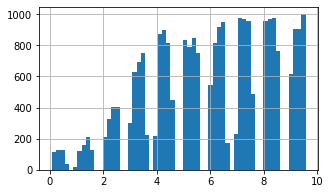

In [31]:
plt.figure(figsize=(5,3))
plt.hist(df_time.time_consum[df_time.time_consum < 9.58], bins =60)
plt.grid()
plt.show()

In [32]:
%%time

percentiles = []
time_segments = [time/10 for time in range(0, 110, 1)]
for sec in tqdm(time_segments):
    _ = df_train['winner'][
                            (df_train.time <= sec) 
                    ].value_counts()
    percentile = (_[1]/_[0])*100
    num1_under_dot = str(sec * 10)[-3:-2]

    if num1_under_dot in ['7','8','9']:
        pass
    else:
        percentiles.append([sec, percentile])
        if sec < 1.2:
            print(f"SEC:{sec:0.4} ... {percentile:0.5}%")

  2%|▏         | 2/110 [00:00<00:14,  7.57it/s]

SEC:0.0 ... 100.23%
SEC:0.1 ... 100.0%


  4%|▎         | 4/110 [00:00<00:15,  6.96it/s]

SEC:0.2 ... 100.18%
SEC:0.3 ... 100.27%


  5%|▍         | 5/110 [00:00<00:16,  6.27it/s]

SEC:0.4 ... 100.14%


  5%|▌         | 6/110 [00:00<00:18,  5.75it/s]

SEC:0.5 ... 100.19%


  6%|▋         | 7/110 [00:01<00:19,  5.30it/s]

SEC:0.6 ... 100.18%


 10%|█         | 11/110 [00:02<00:19,  5.10it/s]

SEC:1.0 ... 100.2%


 11%|█         | 12/110 [00:02<00:21,  4.65it/s]

SEC:1.1 ... 100.23%


100%|██████████| 110/110 [01:08<00:00,  1.60it/s]

CPU times: user 2min 30s, sys: 28.7 s, total: 2min 59s
Wall time: 1min 9s


In [33]:
"""
# 99.45% 이런식으로 잘 안보여서 P1승률 100.59% 형식으로 변경 함
"""
df_percent = pd.DataFrame(percentiles, columns=['sec','percentile'])
df_percent.shape    # (110, 2)
df_percent.head(2)

,sec,percentile
0,0.0,100.229463
1,0.1,99.999856


In [34]:
df_percent.to_csv(dir_base + remake + 'accumujated_winning_rate_per_time.csv')


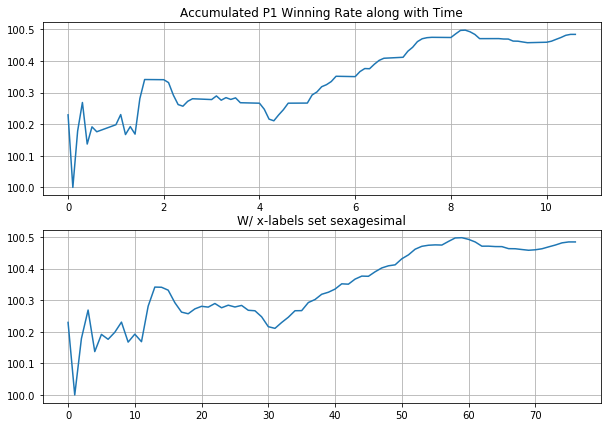

'\n# 중간 데이터를 삭제했는데, 60분법 인덱스 적용이 안되서 수평구간 생김\n'

In [35]:
fig = plt.figure(figsize=(10,7))

fig.add_subplot(211)
plt.plot(df_percent.sec, df_percent.percentile)
plt.title('Accumulated P1 Winning Rate along with Time')
plt.grid()

fig.add_subplot(212)
plt.plot(df_percent.percentile)
plt.title('W/ x-labels set sexagesimal')
plt.grid()
plt.show()

plt.show()

"""
# 중간 데이터를 삭제했는데, 60분법 인덱스 적용이 안되서 수평구간 생김
"""

|class|start time |   | end time |    | winning rage|
|:---:|:---------:|:-:|---------:|:--:|:-----------:|
| 1	  | 0.00 min | ~ |  1.50 min | =  | -341 |
| 2	  | 1.50 min | ~ |  4.20 min | =  |  130 |
| 3	  | 4.20 min | ~ |  8.10 min | =  | -286 |
| 4	  | 8.10 min | ~ | 10.00 min | =  |   39 |
| 5	  |10.00 min | ~ | 10.50 min | =  |  -26 |


|         |         |
|:-------:|:-------:|
| <img src='../_statics/images/winning_graph00.png' width=300> | <img src='../_statics/images/winning_graph02.png' width=400> |

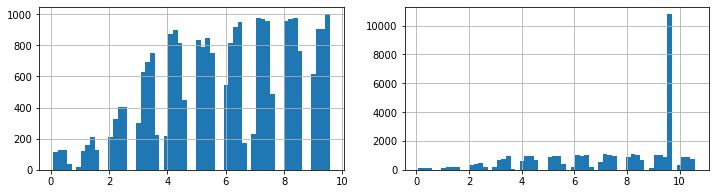

In [36]:
plt.figure(figsize=(12,3))

plt.subplot(121)
plt.hist(df_time.time_consum[df_time.time_consum < 9.58], bins =60)
plt.grid()

plt.subplot(122)
plt.hist(df_time.time_consum[df_time.time_consum > 0], bins =60)
plt.grid()

plt.show()

In [37]:
"""
_= df_train.winner[(df_train.time > 0.6)&
                 (df_train.time <= 0.9)
                ].value_counts()
f"{(_[1]/_[0])*100:0.5}%"
"""
# IndexError: index out of bounds
# 0.7~0.9 까지는 결측치 이기 때문에 범위에 포함시키면 안됨!

'\n_= df_train.winner[(df_train.time > 0.6)&\n                 (df_train.time <= 0.9)\n                ].value_counts()\nf"{(_[1]/_[0])*100:0.5}%"\n'

In [38]:
_= df_train.winner[(df_train.time <= 1.5)
                ].value_counts()
val_1 = (_[1]/_[0])*100
print(f"{val_1:0.6}%")
print(f"{(val_1 - 100)*1000}")

100.281%
280.8888878609821


In [39]:
_= df_train.winner[(df_train.time > 1.5) &
                 (df_train.time <= 4.2)
                ].value_counts()
val_2 = (_[1]/_[0])*100
print(f"{val_2:0.6}%")
print(f"{(val_2 - val_1)*1000:}")

100.172%
-108.93361539881141


In [40]:
_= df_train.winner[(df_train.time > 4.2) &
                 (df_train.time <= 8.1)
                ].value_counts()
val_3 = (_[1]/_[0])*100
print(f"{val_3:0.6}%")
print(f"{(val_3 - val_2)*1000:}")

100.86%
687.5899118453361


In [41]:
_= df_train.winner[(df_train.time > 8.1) &
                 (df_train.time <= 10.00)
                ].value_counts()
val_4 = (_[1]/_[0])*100
print(f"{val_4:0.6}%")
print(f"{(val_4 - val_3)*1000:}")

100.25%
-609.4023521374368


In [42]:
_= df_train.winner[(df_train.time > 10.00)
                ].value_counts()
val_5 = (_[1]/_[0])*100
print(f"{val_5:0.6}%")
print(f"{(val_5 - val_4)*1000:}")

105.164%
4913.865764142557


In [43]:
_= df_train.winner[(df_train.time == 9.58) |
                 (df_train.time == 9.59)
                ].value_counts()
f"{(_[1]/_[0])*100:0.6}%"

'100.568%'

In [44]:
df_train.winner[(df_train.time > 9.6) 
                ].value_counts()

1    192466
0    182810
Name: winner, dtype: int64

## Ability 중 'Train' event count
- 게임별 훈련 이벤트는 거의 필수적으로 존재한다
- 'Train'이 포함된 이벤트를 P0 P1 으로 카운트를 해서 칼럼을 추가한다.
- Train 이벤트가 양쪽 모두 없는 게임이 존재한다 == 뭔가 잘못된 극소수 게임이 존재함

In [45]:
%%time
countAll_train = df_train.game_id[(df_train.event == 'Ability') &
                     (
                         (df_train.event_contents.str.contains('Train')) |
                         (df_train.event_contents.str.contains('Morph'))
                     )
                ].value_counts()


countP0_train = df_train.game_id[(df_train.event == 'Ability') &
                     (
                         (df_train.event_contents.str.contains('Train')) |
                         (df_train.event_contents.str.contains('Morph'))
                     ) &
                     (df_train.player == 0)
                ].value_counts()


countP1_train = df_train.game_id[(df_train.event == 'Ability') &
                     (
                         (df_train.event_contents.str.contains('Train')) |
                         (df_train.event_contents.str.contains('Morph'))
                     ) &
                     (df_train.player == 1)
                ].value_counts()

CPU times: user 4min 45s, sys: 6.83 s, total: 4min 52s
Wall time: 4min 54s


In [46]:
"""
# 갯수 카운트 ... P0=(38717,) P1=(38715,) ALL=(38858,)
"""

df_train_P0 = pd.DataFrame(dict(countP0_train).items(), columns=['game_id','train_P0'])
df_train_P0.index = df_train_P0['game_id'].copy()

df_train_P1 = pd.DataFrame(dict(countP1_train).items(), columns=['game_id','train_P1'])
df_train_P1.index = df_train_P1['game_id'].copy()

df_train_all = pd.DataFrame(dict(countAll_train).items(), columns=['game_id','train_all'])
df_train_all.index = df_train_all['game_id'].copy()
df_train_all = df_train_all.train_all.astype(np.float64)
df_train_all.head(3)

game_id
13458    134.0
5977     127.0
3094     121.0
Name: train_all, dtype: float64

In [47]:
df_1 = pd.concat([df_train_all, df_train_P0, df_train_P1], axis=1, join='outer')
columns = ['train_all', 'train_P0', 'train_P1',]
df_1 = df_1[columns]
df_1 = df_1.fillna(0.0)
df_1['check_sum'] = df_1['train_P0'] + df_1['train_P1']

df_1.shape   # (38858, 4)  ... All 과 갯수가 같음!
df_1.head(6)

,train_all,train_P0,train_P1,check_sum
game_id,,,,
0,24.0,13.0,11.0,24.0
1,54.0,29.0,25.0,54.0
2,63.0,24.0,39.0,63.0
3,54.0,25.0,29.0,54.0
4,38.0,18.0,20.0,38.0
5,58.0,35.0,23.0,58.0


In [48]:
"""
# 합이 맞지 않는다 왜? 그런지 모르겠다.. 안되면 책섬을 트레인올로 바꿔야..
# 조회를 해보니 NaN이 있다 = 0.0으로 바꿔주면 맞을것 같음! --수정완료!
"""

(df_1.train_all == df_1.check_sum).value_counts()

True    38858
dtype: int64

In [49]:
counts['Ability'].shape  # (906693,)
counts['Ability'][:50]

(1360) - TrainSCV                         350376
(1820) - MorphDrone                       287254
(15E0) - TrainProbe                       258765
(13E0) - TrainMarine                      134801
(1822) - MorphOverlord                     90700
(1821) - MorphZergling                     83416
(1E60) - TrainQueen                        51130
(13A0) - LowerSupplyDepot                  42761
(1C60) - UpgradeToOrbitalCommand           34531
(480) - Stop                               30424
(4C2) - HoldPosition                       24828
(1401) - BuildSiegeTank                    19363
(13E1) - TrainReaper                       19301
(1829) - MorphRoach                        18200
(1C80) - TransformToWarpGate               16109
(1420) - TrainMedivac                      15937
(1586) - TrainAdept                        15566
(1405) - BuildHellion                      15001
(17C1) - EvolveMetabolicBoost              14638
(31A0) - MedivacSpeedBoost                 14504
(13C0) - RaiseSupply

In [50]:
%%time
"""
# 위에서 이미 다 반영했음 Train + Morph ... 참고로 결과확인만!
"""
from tqdm import tqdm

dict_remake = {}

for key, val in tqdm(dict(counts['Ability']).items()):
    if ('Train' in key) or ('Morph' in key):
        dict_remake[key] = val
        
    # elif 'Attack' in key:
    #     dict_remake[key] = val
    
    else:
        pass
        
    

100%|██████████| 906693/906693 [00:00<00:00, 1142595.43it/s]


CPU times: user 10.4 s, sys: 50.8 ms, total: 10.4 s
Wall time: 11.3 s


In [51]:
df_ability = pd.DataFrame(dict_remake.items(), columns=['detail', 'count'])

In [52]:
def show_partial_plot(start,end, figsize=(7,3)):
    plt.figure(figsize=figsize)
    range = (start-1, end+1)
    x_labels =np.arange(*range)
    plt.plot(x_labels,list(df_ability['count'])[range[0]:range[1]])
    plt.grid()

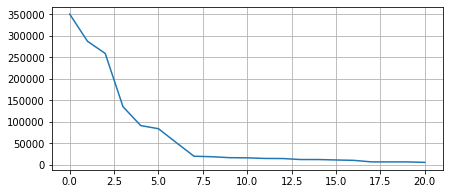

In [53]:
show_partial_plot(1,20, figsize=(7,3))

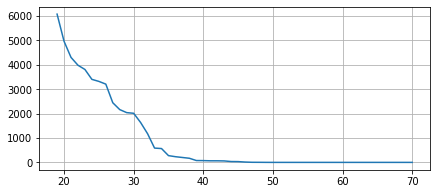

In [54]:
show_partial_plot(20,70, figsize=(7,3))

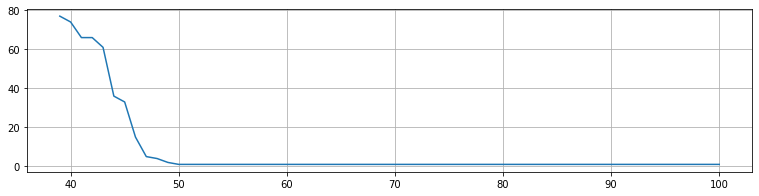

In [55]:
show_partial_plot(40,100, figsize=(13,3))

## Ability 중 'Attack' event count
- 게임별 훈련 이벤트는 거의 필수적으로 존재한다
- 'Attack'이 포함된 이벤트를 P0 P1 으로 카운트를 해서 칼럼을 추가한다.
- Attack 이벤트가 양쪽 모두 없는 게임이 존재한다 == 뭔가 잘못된 극소수 게임이 존재함

In [56]:
%%time
countAll_attack = df_train.game_id[
                     (df_train.event == 'Ability') &
                     (df_train.event_contents.str.contains('Attack'))
                ].value_counts()


countP0_attack = df_train.game_id[
                     (df_train.event == 'Ability') &
                     (df_train.event_contents.str.contains('Attack')) &
                     (df_train.player == 0)
                ].value_counts()


countP1_attack = df_train.game_id[
                     (df_train.event == 'Ability') &
                     (df_train.event_contents.str.contains('Attack')) &
                     (df_train.player == 1)
                ].value_counts()

CPU times: user 2min 7s, sys: 2.57 s, total: 2min 10s
Wall time: 2min 1s


In [57]:
"""
# 갯수 카운트 ...ALL=(33687,)
"""
df_attack_all = pd.DataFrame(dict(countAll_attack).items(), columns=['game_id','attack_all'])
df_attack_all.index = df_attack_all['game_id'].copy()
df_attack_all = df_attack_all.attack_all.astype(np.float64)

df_attack_P0 = pd.DataFrame(dict(countP0_attack).items(), columns=['game_id','attack_P0'])
df_attack_P0.index = df_attack_P0['game_id'].copy()

df_attack_P1 = pd.DataFrame(dict(countP1_attack).items(), columns=['game_id','attack_P1'])
df_attack_P1.index = df_attack_P1['game_id'].copy()

df_attack_all.head(3)

game_id
3547     154.0
7018     142.0
23174    140.0
Name: attack_all, dtype: float64

In [58]:
df_2= pd.concat([df_attack_all, df_attack_P0, df_attack_P1], axis=1, join='outer')
columns = ['attack_all', 'attack_P0', 'attack_P1',]
df_2 = df_2[columns]
df_2 = df_2.fillna(0.0)
df_2['check_attack'] = df_2['attack_P0'] + df_2['attack_P1']

df_2.shape   # (33687, 4)
df_2.head(6)

,attack_all,attack_P0,attack_P1,check_attack
game_id,,,,
0,3.0,0.0,3.0,3.0
1,6.0,2.0,4.0,6.0
2,18.0,11.0,7.0,18.0
3,25.0,8.0,17.0,25.0
4,16.0,14.0,2.0,16.0
5,8.0,7.0,1.0,8.0


In [59]:
"""
# 합이 맞지 않는다 왜? 그런지 모르겠다.. 안되면 책섬을 트레인올로 바꿔야..
# 조회를 해보니 NaN이 있다 = 0.0으로 바꿔주면 맞을것 같음! --수정완료!
"""

(df_2.attack_all == df_2.check_attack).value_counts()

True    33687
dtype: int64

In [60]:
dfs = [df_1, df_2]
df_3 = pd.concat(dfs, axis=1, join='outer')

cols = ['train_P0','attack_P0','train_P1','attack_P1','train_all','attack_all',]
df_3 = df_3[cols]

df_3.shape       # (38862, 6)
df_3.head(6)

,train_P0,attack_P0,train_P1,attack_P1,train_all,attack_all
game_id,,,,,,
0,13.0,0.0,11.0,3.0,24.0,3.0
1,29.0,2.0,25.0,4.0,54.0,6.0
2,24.0,11.0,39.0,7.0,63.0,18.0
3,25.0,8.0,29.0,17.0,54.0,25.0
4,18.0,14.0,20.0,2.0,38.0,16.0
5,35.0,7.0,23.0,1.0,58.0,8.0


In [61]:
cols_x_train = ['game_id', 'time_consum', 'P0_species', 'P0_Ability',
       'P0_AddToControlGroup', 'P0_Camera', 'P0_ControlGroup',
       'P0_GetControlGroup', 'P0_Right Click', 'P0_Selection',
       'P0_SetControlGroup', 'P1_species', 'P1_Ability',
       'P1_AddToControlGroup', 'P1_Camera', 'P1_ControlGroup',
       'P1_GetControlGroup', 'P1_Right Click', 'P1_Selection',
       'P1_SetControlGroup', 'delta_Ability', 'delta_AddToControlGroup',
       'delta_Camera', 'delta_ControlGroup', 'delta_GetControlGroup',
       'delta_Right Click', 'delta_Selection', 'delta_SetControlGroup']

cols_df_time = ['game_id', 'time_consum']
cols_df_null = ['game_id', 'P0_null_total', 'P1_null_total', 'delta_null_total']
cols_df_3 = ['train_P0', 'attack_P0', 'train_P1', 'attack_P1', 'train_all',
       'attack_all']

In [62]:
df_3.columns

Index(['train_P0', 'attack_P0', 'train_P1', 'attack_P1', 'train_all',
       'attack_all'],
      dtype='object')

In [63]:
cols = ['time_consum', 
        'P0_null_total', 
        'P1_null_total', 
        'delta_null_total', 
        
        'train_P0',
        'train_P1', 
        #'delta_train',
        #'train_all', 
        
        'attack_P0',
        'attack_P1',
        #'delta_attack',
        #'attack_all',
       ]

rename_dict = {
        'time_consum'     : 'time',
        'P0_null_total'   : 'p0_null',
        'P1_null_total'   : 'p1_null',
        'delta_null_total': 'delta_null',
    
        'train_P0'        : 'p0_train',
        'train_P1'        : 'p1_train',
        #'train_all'       : 'sum_train',
    
        'attack_P0'       : 'p0_attack',
        'attack_P1'       : 'p1_attack',
        #'attack_all'      : 'sum_attack',
    }

In [64]:
dfs = [df_time, df_null, df_3]
df_remake = pd.concat(dfs, axis=1, join='outer')

df_remake.shape     # (38872, 12)
df_remake = df_remake[cols]
df_remake = df_remake.rename(columns=rename_dict)
df_remake.insert(6, 'delta_train', df_remake.p0_train - df_remake.p1_train  )
df_remake.insert(9,'delta_attack',df_remake.p0_attack - df_remake.p1_attack  )

df_remake.shape     # (38872, 10)
df_remake

,time,p0_null,p1_null,delta_null,p0_train,p1_train,delta_train,p0_attack,p1_attack,delta_attack
0,7.24,29.0,4.0,25.0,13.0,11.0,2.0,0.0,3.0,-3.0
1,9.59,173.0,39.0,134.0,29.0,25.0,4.0,2.0,4.0,-2.0
2,9.59,119.0,125.0,-6.0,24.0,39.0,-15.0,11.0,7.0,4.0
3,9.59,138.0,729.0,-591.0,25.0,29.0,-4.0,8.0,17.0,-9.0
4,5.43,235.0,111.0,124.0,18.0,20.0,-2.0,14.0,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...
38867,8.22,1.0,0.0,1.0,14.0,16.0,-2.0,3.0,0.0,3.0
38868,9.59,0.0,11.0,-11.0,21.0,14.0,7.0,14.0,1.0,13.0
38869,8.25,32.0,97.0,-65.0,23.0,27.0,-4.0,2.0,6.0,-4.0
38870,5.56,13.0,48.0,-35.0,11.0,16.0,-5.0,1.0,0.0,1.0


In [65]:
df_select_null = df_select_null[['P0_select_null','P1_select_null','delta_select_null']]
df_select_null = df_select_null.rename(columns = {
    'P0_select_null' : 'p0_select_null',
    'P1_select_null' : 'p1_select_null',    
})
df_select_null

,p0_select_null,p1_select_null,delta_select_null
game_id,,,
0,5.0,4.0,1.0
1,9.0,2.0,7.0
2,4.0,26.0,-22.0
3,9.0,4.0,5.0
4,3.0,8.0,-5.0
...,...,...,...
38864,24.0,22.0,2.0
38867,3.0,2.0,1.0
38869,2.0,7.0,-5.0


In [66]:
dfs = [df_remake, df_select_null]
df_remake = pd.concat(dfs, axis=1, join='outer')
df_remake

,time,p0_null,p1_null,delta_null,p0_train,p1_train,delta_train,p0_attack,p1_attack,delta_attack,p0_select_null,p1_select_null,delta_select_null
0,7.24,29.0,4.0,25.0,13.0,11.0,2.0,0.0,3.0,-3.0,5.0,4.0,1.0
1,9.59,173.0,39.0,134.0,29.0,25.0,4.0,2.0,4.0,-2.0,9.0,2.0,7.0
2,9.59,119.0,125.0,-6.0,24.0,39.0,-15.0,11.0,7.0,4.0,4.0,26.0,-22.0
3,9.59,138.0,729.0,-591.0,25.0,29.0,-4.0,8.0,17.0,-9.0,9.0,4.0,5.0
4,5.43,235.0,111.0,124.0,18.0,20.0,-2.0,14.0,2.0,12.0,3.0,8.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38867,8.22,1.0,0.0,1.0,14.0,16.0,-2.0,3.0,0.0,3.0,3.0,2.0,1.0
38868,9.59,0.0,11.0,-11.0,21.0,14.0,7.0,14.0,1.0,13.0,NaN,NaN,NaN
38869,8.25,32.0,97.0,-65.0,23.0,27.0,-4.0,2.0,6.0,-4.0,2.0,7.0,-5.0
38870,5.56,13.0,48.0,-35.0,11.0,16.0,-5.0,1.0,0.0,1.0,0.0,3.0,-3.0


In [67]:
show_infoDF_from(df_remake)

*** DATA SHAPE = [ 38,872 x 13 ]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38872 entries, 0 to 38871
Data columns (total 13 columns):
time                 38872 non-null float64
p0_null              38872 non-null float64
p1_null              38872 non-null float64
delta_null           38872 non-null float64
p0_train             38858 non-null float64
p1_train             38858 non-null float64
delta_train          38858 non-null float64
p0_attack            33687 non-null float64
p1_attack            33687 non-null float64
delta_attack         33687 non-null float64
p0_select_null       37339 non-null float64
p1_select_null       37339 non-null float64
delta_select_null    37339 non-null float64
dtypes: float64(13)
memory usage: 4.2 MB
None

               time       p0_null       p1_null    delta_null      p0_train  \
count  38872.000000  38872.000000  38872.000000  38872.000000  38858.000000   
mean       7.289366    136.203643    135.764432      0.439211     18.859771   
s

In [68]:
df_remake.isna().any()

time                 False
p0_null              False
p1_null              False
delta_null           False
p0_train              True
p1_train              True
delta_train           True
p0_attack             True
p1_attack             True
delta_attack          True
p0_select_null        True
p1_select_null        True
delta_select_null     True
dtype: bool

In [69]:
df_remake = df_remake.fillna(0.0)
df_remake.isna().any()

time                 False
p0_null              False
p1_null              False
delta_null           False
p0_train             False
p1_train             False
delta_train          False
p0_attack            False
p1_attack            False
delta_attack         False
p0_select_null       False
p1_select_null       False
delta_select_null    False
dtype: bool

In [70]:
show_infoDF_from(df_remake)

*** DATA SHAPE = [ 38,872 x 13 ]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38872 entries, 0 to 38871
Data columns (total 13 columns):
time                 38872 non-null float64
p0_null              38872 non-null float64
p1_null              38872 non-null float64
delta_null           38872 non-null float64
p0_train             38872 non-null float64
p1_train             38872 non-null float64
delta_train          38872 non-null float64
p0_attack            38872 non-null float64
p1_attack            38872 non-null float64
delta_attack         38872 non-null float64
p0_select_null       38872 non-null float64
p1_select_null       38872 non-null float64
delta_select_null    38872 non-null float64
dtypes: float64(13)
memory usage: 4.2 MB
None

               time       p0_null       p1_null    delta_null      p0_train  \
count  38872.000000  38872.000000  38872.000000  38872.000000  38872.000000   
mean       7.289366    136.203643    135.764432      0.439211     18.852979   
s

In [71]:
show_ls(dir_base + remake)

False
DIR_TARGET=/home/yk/0325_Starcraft/competition/_assets
/home/yk/0325_Starcraft/competition/c03_starcraft_prediction/data_remake/
----------------------------------------
  01. .ipynb_checkpoints
  02. accumujated_winning_rate_per_time.csv
  03. accumulated_winning_rate_per_time.csv
  04. df_new_rate04_correct.csv
  05. df_win_rate_every_10sec.csv
  06. df_win_rate_every_20sec.csv
  07. df_win_rate_every_40sec.csv
  08. df_xtest_remake.csv
  09. df_xtest_remake_final.csv
  10. df_xtrain_remake.csv
  11. df_xtrain_remake_final.csv
  12. df_ytrain_remake.csv
  13. xtra_remake_xtest.csv
  14. xtra_remake_xtest_final.csv
  15. xtra_remake_xtrain.csv
  16. xtra_remake_xtrain_final.csv


In [ ]:
show_ls()

In [80]:
df_new_rate04 = pd.read_csv('df_win_rate_every_40sec.csv', index_col='Unnamed: 0')
df_new_rate04 = df_new_rate04.rename(columns={'time_consume':'time_span'})

df_new_rate02 = pd.read_csv('df_win_rate_every_20sec.csv', index_col='Unnamed: 0')
df_new_rate02 = df_new_rate02.rename(columns={'time_consume':'time_span'})

df_new_rate01 = pd.read_csv('df_win_rate_every_10sec.csv', index_col='Unnamed: 0')
df_new_rate01 = df_new_rate04.rename(columns={'time_consume':'time_span'})

df_new_rate01.head()

,time_span,P0_win,P1_win,delta_win,P0_rate,P1_rate,delta_rate
0,0.4,128,121,7,51.405622,48.594378,2.811245
1,1.2,88,78,10,53.012048,46.987952,6.024096
2,1.6,235,235,0,50.000000,50.000000,0.000000
3,2.0,7,3,4,70.000000,30.000000,40.000000
4,2.4,401,392,9,50.567465,49.432535,1.134931


In [90]:
"""
# pool-4 & 1 are the same!!! .... something might went wrong!
"""

df_new_rate04.head()

,time_span,P0_win,P1_win,delta_win,P0_rate,P1_rate,delta_rate
0,0.4,128,121,7,51.405622,48.594378,2.811245
1,1.2,88,78,10,53.012048,46.987952,6.024096
2,1.6,235,235,0,50.000000,50.000000,0.000000
3,2.0,7,3,4,70.000000,30.000000,40.000000
4,2.4,401,392,9,50.567465,49.432535,1.134931


In [81]:
"""
# 람다펑션에 넣을 헬퍼함수를 정의한다
# p0_weight 칼럼을 만들기 위한 함수
"""
def get_index(time, dict_rate):
    """
    # 
    """
    i = 0
    while i <= len(dict_rate['time_span']):
        time_seg = dict_rate['time_span'][i]
        if time < time_seg:
            weight = dict_rate['delta_rate'][i]
            # print(f"{time} is less than {time_seg}, Weight = {weight}")  # FOR TEST!
            return weight
            break
        i += 1
    return False

In [85]:
dict_rate04 = df_new_rate04.to_dict()
dict_rate02 = df_new_rate02.to_dict()
dict_rate01 = df_new_rate01.to_dict()

# *** Something Might Wrong on Pool-1 & 4

In [89]:
time_spend = 7.4

print(f"POOL-04 WEIGHT = {get_index(time_spend, dict_rate04)}")
print(f"POOL-02 WEIGHT = {get_index(time_spend, dict_rate02)}")
print(f"POOL-01 WEIGHT = {get_index(time_spend, dict_rate01)}")

POOL-04 WEIGHT = 1.203819012038181
POOL-02 WEIGHT = 2.5041736227045064
POOL-01 WEIGHT = 1.203819012038181


In [72]:


_ = get_index(0.2, dict_rate04)

times = list(df_remake.time[:10])
weights = []

for time in times:
    weights.append(get_index(time, dict_rate04))

weights

[2.118644068,
 0.308153577,
 0.308153577,
 0.308153577,
 2.459396752,
 0.308153577,
 2.118644068,
 2.118644068,
 0.308153577,
 6.330837304]

In [73]:
df_remake['p0_weight'] = df_remake['time'].apply(lambda x: get_index(x, dict_rate04))
df_remake

,time,p0_null,p1_null,delta_null,p0_train,p1_train,delta_train,p0_attack,p1_attack,delta_attack,p0_select_null,p1_select_null,delta_select_null,p0_weight
0,7.24,29.0,4.0,25.0,13.0,11.0,2.0,0.0,3.0,-3.0,5.0,4.0,1.0,2.118644
1,9.59,173.0,39.0,134.0,29.0,25.0,4.0,2.0,4.0,-2.0,9.0,2.0,7.0,0.308154
2,9.59,119.0,125.0,-6.0,24.0,39.0,-15.0,11.0,7.0,4.0,4.0,26.0,-22.0,0.308154
3,9.59,138.0,729.0,-591.0,25.0,29.0,-4.0,8.0,17.0,-9.0,9.0,4.0,5.0,0.308154
4,5.43,235.0,111.0,124.0,18.0,20.0,-2.0,14.0,2.0,12.0,3.0,8.0,-5.0,2.459397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38867,8.22,1.0,0.0,1.0,14.0,16.0,-2.0,3.0,0.0,3.0,3.0,2.0,1.0,6.127353
38868,9.59,0.0,11.0,-11.0,21.0,14.0,7.0,14.0,1.0,13.0,0.0,0.0,0.0,0.308154
38869,8.25,32.0,97.0,-65.0,23.0,27.0,-4.0,2.0,6.0,-4.0,2.0,7.0,-5.0,6.127353
38870,5.56,13.0,48.0,-35.0,11.0,16.0,-5.0,1.0,0.0,1.0,0.0,3.0,-3.0,4.000000


In [74]:
df_remake.isna().any()

time                 False
p0_null              False
p1_null              False
delta_null           False
p0_train             False
p1_train             False
delta_train          False
p0_attack            False
p1_attack            False
delta_attack         False
p0_select_null       False
p1_select_null       False
delta_select_null    False
p0_weight            False
dtype: bool

In [75]:
show_infoDF_from(df_remake)

*** DATA SHAPE = [ 38,872 x 14 ]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38872 entries, 0 to 38871
Data columns (total 14 columns):
time                 38872 non-null float64
p0_null              38872 non-null float64
p1_null              38872 non-null float64
delta_null           38872 non-null float64
p0_train             38872 non-null float64
p1_train             38872 non-null float64
delta_train          38872 non-null float64
p0_attack            38872 non-null float64
p1_attack            38872 non-null float64
delta_attack         38872 non-null float64
p0_select_null       38872 non-null float64
p1_select_null       38872 non-null float64
delta_select_null    38872 non-null float64
p0_weight            38872 non-null float64
dtypes: float64(14)
memory usage: 4.4 MB
None

               time       p0_null       p1_null    delta_null      p0_train  \
count  38872.000000  38872.000000  38872.000000  38872.000000  38872.000000   
mean       7.289366    136.203643   

In [96]:
dfs = [x_train, df_remake]
df_remake_01 = pd.concat(dfs, axis=1, join='outer')
df_remake_01 = df_remake_01.rename(columns={'time_consum' : 'time',})
df_remake_01.index = df_remake_01['game_id'].copy()


In [97]:
df_remake_01

,game_id,time,P0_species,P0_Ability,P0_AddToControlGroup,P0_Camera,P0_ControlGroup,P0_GetControlGroup,P0_Right Click,P0_Selection,...,p0_train,p1_train,delta_train,p0_attack,p1_attack,delta_attack,p0_select_null,p1_select_null,delta_select_null,p0_weight
game_id,,,,,,,,,,,,,,,,,,,,,
0,0,7.24,0,34.0,2.0,444.0,0.0,24.0,35.0,50.0,...,13.0,11.0,2.0,0.0,3.0,-3.0,5.0,4.0,1.0,2.118644
1,1,9.59,1,77.0,1.0,627.0,0.0,162.0,160.0,186.0,...,29.0,25.0,4.0,2.0,4.0,-2.0,9.0,2.0,7.0,0.308154
2,2,9.59,1,69.0,6.0,413.0,0.0,99.0,160.0,90.0,...,24.0,39.0,-15.0,11.0,7.0,4.0,4.0,26.0,-22.0,0.308154
3,3,9.59,0,82.0,0.0,713.0,0.0,132.0,276.0,180.0,...,25.0,29.0,-4.0,8.0,17.0,-9.0,9.0,4.0,5.0,0.308154
4,4,5.43,0,57.0,1.0,430.0,0.0,224.0,177.0,67.0,...,18.0,20.0,-2.0,14.0,2.0,12.0,3.0,8.0,-5.0,2.459397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38867,38867,8.22,0,43.0,0.0,639.0,0.0,0.0,95.0,53.0,...,14.0,16.0,-2.0,3.0,0.0,3.0,3.0,2.0,1.0,6.127353
38868,38868,9.59,0,63.0,0.0,558.0,0.0,0.0,123.0,62.0,...,21.0,14.0,7.0,14.0,1.0,13.0,0.0,0.0,0.0,0.308154
38869,38869,8.25,1,56.0,0.0,785.0,0.0,28.0,248.0,106.0,...,23.0,27.0,-4.0,2.0,6.0,-4.0,2.0,7.0,-5.0,6.127353


In [98]:
df_remake_01.isna().any()

game_id                    False
time                       False
P0_species                 False
P0_Ability                 False
P0_AddToControlGroup       False
P0_Camera                  False
P0_ControlGroup            False
P0_GetControlGroup         False
P0_Right Click             False
P0_Selection               False
P0_SetControlGroup         False
P1_species                 False
P1_Ability                 False
P1_AddToControlGroup       False
P1_Camera                  False
P1_ControlGroup            False
P1_GetControlGroup         False
P1_Right Click             False
P1_Selection               False
P1_SetControlGroup         False
delta_Ability              False
delta_AddToControlGroup    False
delta_Camera               False
delta_ControlGroup         False
delta_GetControlGroup      False
delta_Right Click          False
delta_Selection            False
delta_SetControlGroup      False
time                       False
p0_null                    False
p1_null   

In [108]:
df_remake_01.insert(1, 'time_spend', df_time['time_consum'])

In [112]:
del(df_remake_01['time'])

In [113]:
df_remake_01

,game_id,time_spend,P0_species,P0_Ability,P0_AddToControlGroup,P0_Camera,P0_ControlGroup,P0_GetControlGroup,P0_Right Click,P0_Selection,...,p0_train,p1_train,delta_train,p0_attack,p1_attack,delta_attack,p0_select_null,p1_select_null,delta_select_null,p0_weight
game_id,,,,,,,,,,,,,,,,,,,,,
0,0,7.24,0,34.0,2.0,444.0,0.0,24.0,35.0,50.0,...,13.0,11.0,2.0,0.0,3.0,-3.0,5.0,4.0,1.0,2.118644
1,1,9.59,1,77.0,1.0,627.0,0.0,162.0,160.0,186.0,...,29.0,25.0,4.0,2.0,4.0,-2.0,9.0,2.0,7.0,0.308154
2,2,9.59,1,69.0,6.0,413.0,0.0,99.0,160.0,90.0,...,24.0,39.0,-15.0,11.0,7.0,4.0,4.0,26.0,-22.0,0.308154
3,3,9.59,0,82.0,0.0,713.0,0.0,132.0,276.0,180.0,...,25.0,29.0,-4.0,8.0,17.0,-9.0,9.0,4.0,5.0,0.308154
4,4,5.43,0,57.0,1.0,430.0,0.0,224.0,177.0,67.0,...,18.0,20.0,-2.0,14.0,2.0,12.0,3.0,8.0,-5.0,2.459397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38867,38867,8.22,0,43.0,0.0,639.0,0.0,0.0,95.0,53.0,...,14.0,16.0,-2.0,3.0,0.0,3.0,3.0,2.0,1.0,6.127353
38868,38868,9.59,0,63.0,0.0,558.0,0.0,0.0,123.0,62.0,...,21.0,14.0,7.0,14.0,1.0,13.0,0.0,0.0,0.0,0.308154
38869,38869,8.25,1,56.0,0.0,785.0,0.0,28.0,248.0,106.0,...,23.0,27.0,-4.0,2.0,6.0,-4.0,2.0,7.0,-5.0,6.127353


In [114]:
show_infoDF_from(df_remake_01)

*** DATA SHAPE = [ 38,872 x 41 ]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38872 entries, 0 to 38871
Data columns (total 41 columns):
game_id                    38872 non-null int64
time_spend                 38872 non-null float64
P0_species                 38872 non-null int64
P0_Ability                 38872 non-null float64
P0_AddToControlGroup       38872 non-null float64
P0_Camera                  38872 non-null float64
P0_ControlGroup            38872 non-null float64
P0_GetControlGroup         38872 non-null float64
P0_Right Click             38872 non-null float64
P0_Selection               38872 non-null float64
P0_SetControlGroup         38872 non-null float64
P1_species                 38872 non-null int64
P1_Ability                 38872 non-null float64
P1_AddToControlGroup       38872 non-null float64
P1_Camera                  38872 non-null float64
P1_ControlGroup            38872 non-null float64
P1_GetControlGroup         38872 non-null float64
P1_Right Clic

# final xtrain data set 저장
- final xtrain,
- final ytrain,
- final xtest = 최종시험!

In [116]:
df_remake_01.to_csv(filename_remake_final)